##Libraries and Dataset Preprocessing

In [ ]:
!pip install tensorflow matplotlib tensorflow-datasets ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.7 MB/s eta 0:00:00


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [3]:
ds = tfds.load("fashion_mnist", split = "train")  #gettting the train split of the dataset

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.8CVIYC_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.8CVIYC_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
ds.as_numpy_iterator().next()['label']  # Converts the dataset to a NumPy iterator, Takes the first element from it, Returns only the label of that element

np.int64(2)

##Visualise Data and Build Dataset

In [5]:
import numpy as np

In [6]:
dataiterator = ds.as_numpy_iterator() # Python iterator that yields NumPy arrays

In [7]:
nextiter = dataiterator.next() # getting the next element which are basically an dictionary of arrays
nextiter['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

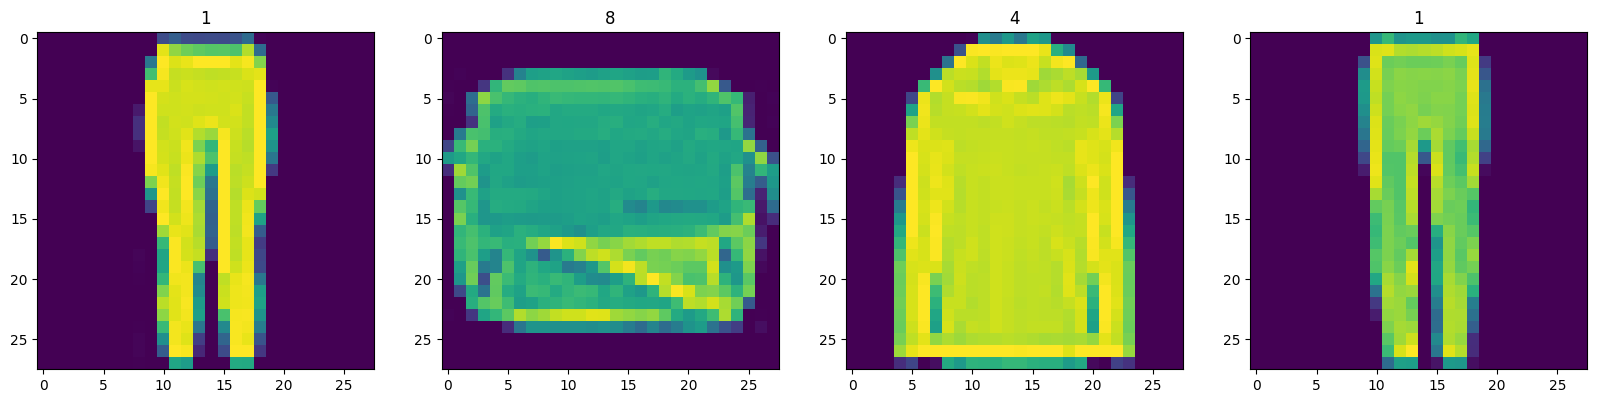

In [8]:
fig, ax = plt.subplots( ncols = 4, figsize = (20,20)) # 1 row 4 columns , ax represent the array of 4 indexes
for idx in range(4):
  sample = dataiterator.next()
  ax[idx].imshow(np.squeeze(sample['image'])) # squeeze the dimension of image 28 *28 *1 to 28* 28
  ax[idx].title.set_text(sample['label'])


In [9]:
# standardize the image pixel to [0,1]
def scale_images(data):  # data a dict of dataset with keys 'label' and 'image'
  image = data['image'] # 3d array of pixels, 0 - 255
  return image / 255 # only return the image but not label


In [15]:
ds.cardinality().numpy()  #total dataset

np.int64(60000)

In [18]:
ds = tfds.load("fashion_mnist", split = "train") # need to pass the raw tf dataset
ds = ds.map(scale_images)
ds = ds.cache() # cache in memory for faster training for each epochs
ds = ds.shuffle(60000) # randomise with buffer size = 60k i.e all
ds = ds.batch(128) # batch of each size 128
ds = ds.prefetch(64) # prefetch 64 batches ahead to handle Input bottlenecking

In [19]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [20]:
# TensorFlow Keras Sequential API
# Used to build models layer-by-layer in a linear stack
from tensorflow.keras.models import Sequential

# Core neural network layers for GANs
from tensorflow.keras.layers import (
    Conv2D,      # 2D Convolution layer: extracts spatial features from images (used in Discriminator)
    Dense,       # Fully connected layer: connects every input neuron to every output neuron
    Flatten,     # Flattens multi-dimensional input to 1D (e.g., image → vector)
    Reshape,     # Reshapes 1D vector into multi-dimensional tensor (e.g., vector → image)
    LeakyReLU,   # Activation function: allows small gradient when inputs are negative (helps GAN training)
    Dropout,     # Randomly sets fraction of inputs to 0 during training (prevents overfitting)
    UpSampling2D # Upsamples 2D data (increases image size, used in Generator for image growth)
)


##Generator

In [23]:
def build_generator():
  model = Sequential()

  # a dense layer with input as 128 random number ( noise vector ) and output as ( 7 * 7* 128 = 6272) values
  model.add(Dense(7*7*128, input_dim = 128))
  model.add(LeakyReLU(0.2)) # introduce non-linearity with small gradient for negative inputs
  model.add(Reshape((7,7,128))) # Turns the 1D vector of 6272 values into a 3D tensor: 7x7 pixels with 128 feature channels.

  model.add(UpSampling2D())  # doubles the width and height of the image → 7×7 → 14×14.
  model.add(Conv2D(128, 5, padding='same')) # convolution layer that detects patterns, 128 filters each size 5 * 5, keeps the image unchanged
  model.add(LeakyReLU(0.2))

  model.add(UpSampling2D())  # 28*28
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(1, 4, padding='same', activation='sigmoid')) # 1 filter - reduces channel to one -> graysavle image , Activation sigmoid: ensures all pixel values are between 0 and 1.

  return model

In [24]:
generator = build_generator()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
generator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,155,137 (8.22 MB)

 Trainable params: 2,155,137 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
img = generator.predict(np.random.rand(4,128,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


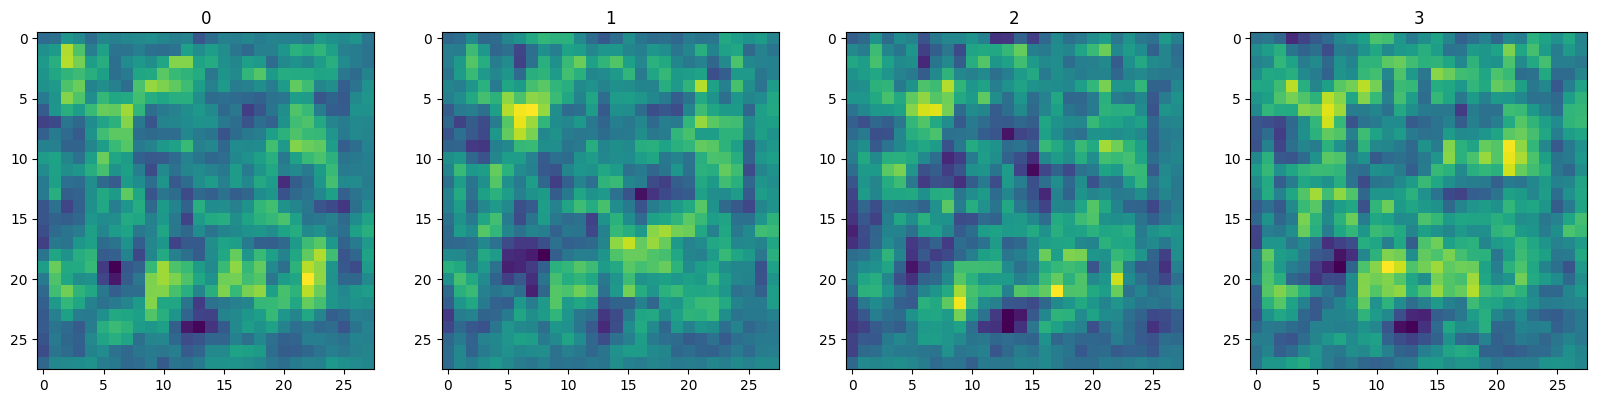

In [27]:
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx, img in enumerate(img):
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title
    ax[idx].title.set_text(idx)

##Discriminator

In [28]:
def build_discriminator():
    model = Sequential()

    # filter => the number of feature map the model will learn
    model.add(Conv2D(32, 5, input_shape = (28,28,1))) # 32 filters → detect simple features (edges, lines)
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4)) # Randomly sets 40% of the inputs to 0 , prevents overfitting

    model.add(Conv2D(64, 5)) # 64, 128 → detect more complex patterns (textures, shapes).
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Flatten()) # convert the multi dimensional feature map to 1D vector
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid')) # 1 output , maps the output to [0,1]

    return model

In [29]:
discriminator = build_discriminator()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
discriminator.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        36,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,113,345 (4.25 MB)

 Trainable params: 1,113,345 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
img[0].shape

(28, 28, 1)

In [47]:
#require to add batch as well
single_img = np.expand_dims(img[0], axis=0)
single_img.shape

(1, 28, 28, 1)

In [48]:
discriminator.predict(single_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


array([[0.50180495]], dtype=float32)

##Constructing the Training Loop